# Risk Analyzer 


In [4]:
# Imports 

import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [5]:
pip install hvplot

---



### Import the csv into a Pandas DataFrame.

In [6]:
# Import the GOOG.csv into a Pandas Dataframe
goog_df = pd.read_csv(Path("/content/GOOG.csv"),
                       index_col='Date',
                       infer_datetime_format=True,
                       parse_dates=True)

# Review the DataFrame
goog_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-16,849.030029,850.849976,846.130005,848.780029,848.780029,977600
2017-03-17,851.609985,853.400024,847.109985,852.119995,852.119995,1712300
2017-03-20,850.010010,850.219971,845.150024,848.400024,848.400024,1231500
2017-03-21,851.400024,853.500000,829.020020,830.460022,830.460022,2463500
2017-03-22,831.909973,835.549988,827.179993,829.590027,829.590027,1401500


In [7]:
# Filter the close column
G_signals_df = goog_df.loc[:, ["Close"]]

# pct_change function to generate returns from close prices
G_signals_df["Actual Returns"] = G_signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
G_signals_df = G_signals_df.dropna()

# Review the DataFrame
display(G_signals_df.head())
display(G_signals_df.tail())

,Close,Actual Returns
Date,,
2017-03-17,852.119995,0.003935
2017-03-20,848.400024,-0.004366
2017-03-21,830.460022,-0.021146
2017-03-22,829.590027,-0.001048
2017-03-23,817.580017,-0.014477


,Close,Actual Returns
Date,,
2022-03-10,2653.639893,-0.008845
2022-03-11,2609.510010,-0.016630
2022-03-14,2534.820068,-0.028622
2022-03-15,2593.209961,0.023035
2022-03-15,2593.209961,0.000000


## Generate trading signals using short- and long-window SMA values. 

In [8]:
# Set the short window and long window
short_window = 50
long_window = 100

# Generate the fast and slow simple moving averages 
G_signals_df['SMA_Fast'] = G_signals_df['Close'].rolling(window=short_window).mean()
G_signals_df['SMA_Slow'] = G_signals_df['Close'].rolling(window=long_window).mean()
G_signals_df['Signal'] = 0.0
G_signals_df = G_signals_df.dropna()

# Review the DataFrame
display(G_signals_df.head())
display(G_signals_df.tail())


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2017-08-08,926.789978,-0.002765,946.997806,912.359602,0.0
2017-08-09,922.900024,-0.004197,945.938207,913.067402,0.0
2017-08-10,907.239990,-0.016968,944.785807,913.655802,0.0
2017-08-11,914.390015,0.007881,943.734607,914.495102,0.0
2017-08-14,922.669983,0.009055,942.676007,915.425901,0.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-03-10,2653.639893,-0.008845,2723.464019,2820.355613,0.0
2022-03-11,2609.510010,-0.016630,2717.052417,2817.858613,0.0
2022-03-14,2534.820068,-0.028622,2709.347817,2814.442415,0.0
2022-03-15,2593.209961,0.023035,2703.340215,2811.891514,0.0
2022-03-15,2593.209961,0.000000,2697.174614,2809.267512,0.0


In [9]:
# Initialize the new Signal column
#G_signals_df['Signal'] = 0.0

# Generate the trading signal 0 or 1,
# where 1 is the short-window (SMA_Fast) greater than the long-window (SMA_Slow)
# and 0 is when the condition is not met
G_signals_df["Signal"][short_window:] = np.where(
    G_signals_df["SMA_Slow"][short_window:] < G_signals_df["SMA_Fast"][short_window:], 1.0, 0.0
)

# Review the DataFrame
G_signals_df.tail(10)

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-03-03,2686.159912,-0.003291,2755.628418,2829.182512,0.0
2022-03-04,2642.439941,-0.016276,2750.789019,2827.837412,0.0
2022-03-07,2529.290039,-0.042820,2742.595220,2825.787712,0.0
2022-03-08,2545.570068,0.006437,2734.649619,2823.663413,0.0
2022-03-09,2677.320068,0.051757,2728.970420,2822.154214,0.0
2022-03-10,2653.639893,-0.008845,2723.464019,2820.355613,0.0
2022-03-11,2609.510010,-0.016630,2717.052417,2817.858613,0.0
2022-03-14,2534.820068,-0.028622,2709.347817,2814.442415,0.0
2022-03-15,2593.209961,0.023035,2703.340215,2811.891514,0.0


In [10]:
G_signals_df['Signal'].value_counts()

1.0    840
0.0    320
Name: Signal, dtype: int64

In [11]:
# Calculate the strategy returns and add them to the signals_df DataFrame
G_signals_df['Strategy Returns'] = G_signals_df['Actual Returns'] * G_signals_df['Signal'].shift()

# Review the DataFrame
display(G_signals_df.head())
display(G_signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2017-08-08,926.789978,-0.002765,946.997806,912.359602,0.0,NaN
2017-08-09,922.900024,-0.004197,945.938207,913.067402,0.0,-0.0
2017-08-10,907.239990,-0.016968,944.785807,913.655802,0.0,-0.0
2017-08-11,914.390015,0.007881,943.734607,914.495102,0.0,0.0
2017-08-14,922.669983,0.009055,942.676007,915.425901,0.0,0.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-03-10,2653.639893,-0.008845,2723.464019,2820.355613,0.0,-0.0
2022-03-11,2609.510010,-0.016630,2717.052417,2817.858613,0.0,-0.0
2022-03-14,2534.820068,-0.028622,2709.347817,2814.442415,0.0,-0.0
2022-03-15,2593.209961,0.023035,2703.340215,2811.891514,0.0,0.0
2022-03-15,2593.209961,0.000000,2697.174614,2809.267512,0.0,0.0


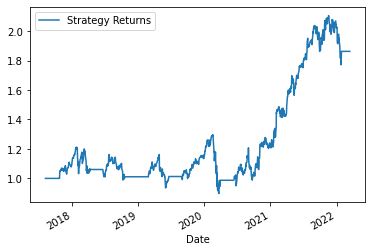

In [12]:
# Plot Strategy Returns to examine performance
(1 + G_signals_df[['Strategy Returns']]).cumprod().plot()

In [13]:
# Calculate the points in time at which a position should be taken, 1 or -1
G_signals_df['Entry/Exit'] = G_signals_df['Signal'].diff()

# Review the DataFrame
G_signals_df.tail(10)

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Entry/Exit
Date,,,,,,,
2022-03-03,2686.159912,-0.003291,2755.628418,2829.182512,0.0,-0.0,0.0
2022-03-04,2642.439941,-0.016276,2750.789019,2827.837412,0.0,-0.0,0.0
2022-03-07,2529.290039,-0.042820,2742.595220,2825.787712,0.0,-0.0,0.0
2022-03-08,2545.570068,0.006437,2734.649619,2823.663413,0.0,0.0,0.0
2022-03-09,2677.320068,0.051757,2728.970420,2822.154214,0.0,0.0,0.0
2022-03-10,2653.639893,-0.008845,2723.464019,2820.355613,0.0,-0.0,0.0
2022-03-11,2609.510010,-0.016630,2717.052417,2817.858613,0.0,-0.0,0.0
2022-03-14,2534.820068,-0.028622,2709.347817,2814.442415,0.0,-0.0,0.0
2022-03-15,2593.209961,0.023035,2703.340215,2811.891514,0.0,0.0,0.0


### Backtesting The Strategy

In [14]:
# Set the initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
G_signals_df["Position"] = share_size * G_signals_df["Signal"]

# Find the points in time where a 500 share position is bought or sold
G_signals_df["Entry/Exit Position"] = G_signals_df["Position"].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
G_signals_df["Portfolio Holdings"] = (
    G_signals_df["Close"] * G_signals_df["Entry/Exit Position"].cumsum()
)

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
G_signals_df["Portfolio Cash"] = (
    initial_capital - (G_signals_df["Close"] * G_signals_df["Entry/Exit Position"]).cumsum()
)

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
G_signals_df["Portfolio Total"] = (
    G_signals_df["Portfolio Cash"] + G_signals_df["Portfolio Holdings"]
)

# Calculate the portfolio daily returns
G_signals_df["Portfolio Daily Returns"] = G_signals_df["Portfolio Total"].pct_change()

# Calculate the cumulative returns
G_signals_df["Portfolio Cumulative Returns"] = (
    1 + G_signals_df["Portfolio Daily Returns"]
).cumprod() - 1


# Print the DataFrame
G_signals_df.head(10).dropna()



,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2017-08-10,907.239990,-0.016968,944.785807,913.655802,0.0,-0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-11,914.390015,0.007881,943.734607,914.495102,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-14,922.669983,0.009055,942.676007,915.425901,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-15,922.219971,-0.000488,941.446807,916.472301,0.0,-0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-16,926.960022,0.005140,940.454607,917.597601,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-17,910.979980,-0.017239,939.055406,918.512301,0.0,-0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-18,910.669983,-0.000340,937.600607,919.409801,0.0,-0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2017-08-21,906.659973,-0.004403,936.737206,920.162301,0.0,-0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0


## Plot Entry/Exit Points of Backtest Results

In [15]:
# Visualize exit positions relative to total portfolio value
entry = G_signals_df[G_signals_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize entry positions relative to total portfolio value
exit = G_signals_df[G_signals_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the total portoflio value 
total_portfolio_value = G_signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="GOOGLE - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

### Prepare Portfolio Evaluation Metrics DataFrame

In [16]:
# Create the list of the metric names
metrics = [
    'Annualized Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio'
]

# Create a list that holds the column name
columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and columns 
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [17]:
# Calculate the Annualized return metric
portfolio_evaluation_df.loc['Annualized Return'] = (
    G_signals_df['Portfolio Daily Returns'].mean() * 252
)

# Calculate the Cumulative returns metric
portfolio_evaluation_df.loc['Cumulative Returns'] = G_signals_df['Portfolio Cumulative Returns'][-1]

# Calculate the Annual volatility metric
portfolio_evaluation_df.loc['Annual Volatility'] = (
    G_signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate the Sharpe ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    G_signals_df['Portfolio Daily Returns'].mean() * 252) / (
    G_signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)


In [18]:
G_signals_df = G_signals_df.loc[:,~G_signals_df.columns.duplicated()]


In [41]:
# Calculate the Sortino ratio
# Start by calculating the downside return values

# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = G_signals_df[['Portfolio Daily Returns']]

# Create a column to hold downside return values
sortino_ratio_df.loc[:,'Downside Returns'] = 0

# Find Portfolio Daily Returns values less than 0, 
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df['Portfolio Daily Returns'] < 0, 
                     'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

# Calculate the annualized return value
annualized_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252

# Calculate the annualized downside standard deviation value
downside_standard_deviation = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)

# Divide the annualized return value by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio

# Review the portfolio evaluation DataFrame
portfolio_evaluation_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Backtest
Annualized Return,1.121152
Cumulative Returns,6.14645
Annual Volatility,1.205326
Sharpe Ratio,0.930165
Sortino Ratio,1.515612


### Split the data into training and testing datasets.

In [20]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = G_signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2017-08-09,946.997806,912.359602
2017-08-10,945.938207,913.067402
2017-08-11,944.785807,913.655802
2017-08-14,943.734607,914.495102
2017-08-15,942.676007,915.425901


In [21]:
# Create the target set selecting the Signal column and assiging it to y
y = G_signals_df['Signal']

# Review the value counts
y.value_counts()

1.0    840
0.0    320
Name: Signal, dtype: int64

In [22]:
# Select the start of the training period
training_begin = X.index.min()
#training_begin = pd.to_datetime("2019-01-01 00:00:00")
#training_begin = pd.to_datetime("2018-01-01 00:00:00")

# Display the training begin date
print(training_begin)

2017-08-09 00:00:00


In [23]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
#training_end = training_begin + DateOffset(months=12)
#training_end = pd.to_datetime("2019-12-31 00:00:00")

# Display the training end date
print(training_end)

2017-11-09 00:00:00


In [24]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())


,SMA_Fast,SMA_Slow
Date,,
2017-08-09,946.997806,912.359602
2017-08-10,945.938207,913.067402
2017-08-11,944.785807,913.655802
2017-08-14,943.734607,914.495102
2017-08-15,942.676007,915.425901


,SMA_Fast,SMA_Slow
Date,,
2017-11-03,956.674602,946.259803
2017-11-06,958.898601,947.077003
2017-11-07,961.098801,947.912903
2017-11-08,963.489200,948.848403
2017-11-09,965.860400,949.673202


In [25]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
Date,,
2017-11-10,967.894200,950.479503
2017-11-13,969.668999,951.165702
2017-11-14,971.437199,951.852302
2017-11-15,973.388198,952.456401
2017-11-16,975.250198,953.142801


,SMA_Fast,SMA_Slow
Date,,
2022-03-10,2728.970420,2822.154214
2022-03-11,2723.464019,2820.355613
2022-03-14,2717.052417,2817.858613
2022-03-15,2709.347817,2814.442415
2022-03-15,2703.340215,2811.891514


In [26]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Use the `SVC` classifier model to fit the training data and make predictions based on the testing data

In [27]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred[-10:])
print(y_test[-10:].values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Review the classification report associated with the `SVC` model predictions. 

In [28]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test,svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.24      1.00      0.39       266
         1.0       1.00      0.01      0.02       827

    accuracy                           0.25      1093
   macro avg       0.62      0.50      0.21      1093
weighted avg       0.82      0.25      0.11      1093



In [29]:
G_signals_df[G_signals_df.index.duplicated()]

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2022-03-15,2593.209961,0.0,2697.174614,2809.267512,0.0,0.0,0.0,0.0,0.0,0.0,714644.989,714644.989,0.0,6.14645


In [30]:
G_signals_df = G_signals_df[~G_signals_df.index.duplicated()]

### Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [31]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = G_signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2017-11-10,1.0,-0.003093,-0.003093
2017-11-13,1.0,-0.002257,-0.002257
2017-11-14,1.0,0.000244,0.000244
2017-11-15,1.0,-0.004961,-0.004961
2017-11-16,1.0,0.011353,0.011353


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-03-10,0.0,-0.008845,-0.0
2022-03-11,0.0,-0.016630,-0.0
2022-03-14,0.0,-0.028622,-0.0
2022-03-15,0.0,0.023035,0.0
2022-03-15,0.0,0.023035,0.0


### A cumulative return plot that shows the actual returns vs. the strategy returns

In [32]:
# Plot the actual returns versus the strategy returns
returns_plot = (1 + predictions_df[["Actual Returns","Strategy Returns"]]).cumprod().hvplot(width = 1000, height = 400)
returns_plot
                

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

---

## New Machine Learning Classifier



### Import a new classifier `LogisticRegression`

In [33]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
loreg_model = LogisticRegression()


In [34]:
# Fit the model using the training data
loreg_model = loreg_model.fit(X_train_scaled,y_train)

# Use the testing dataset to generate the predictions for the new model
pred = loreg_model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Backtest the new model to evaluate its performance. 


In [35]:
# Use a classification report to evaluate the model using the predictions and testing data
training_report = classification_report(y_test,pred)

# Print the classification report
print(training_report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       266
         1.0       0.76      1.00      0.86       827

    accuracy                           0.76      1093
   macro avg       0.38      0.50      0.43      1093
weighted avg       0.57      0.76      0.65      1093



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df["Predictions"] = pred

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = G_signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Algorithm Returns"] = predictions_df["Predictions"] * predictions_df["Actual Returns"]

# Review the DataFrame
predictions_df


,Predictions,Actual Returns,Algorithm Returns
Date,,,
2017-11-10,1.0,-0.003093,-0.003093
2017-11-13,1.0,-0.002257,-0.002257
2017-11-14,1.0,0.000244,0.000244
2017-11-15,1.0,-0.004961,-0.004961
2017-11-16,1.0,0.011353,0.011353
...,...,...,...
2022-03-10,1.0,-0.008845,-0.008845
2022-03-11,1.0,-0.016630,-0.016630
2022-03-14,1.0,-0.028622,-0.028622


In [40]:
# Plot the actual returns versus the strategy returns
returns_plot2 = (1 + predictions_df[["Actual Returns","Algorithm Returns"]]).cumprod().hvplot()
returns_plot2

:NdOverlay   [Variable]
   :Curve   [Date]   (value)